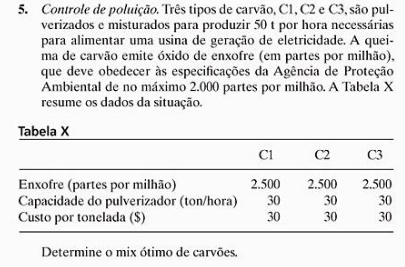

In [4]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Controle_Poluicao_Carvao')

In [6]:
# --- Parâmetros extraídos do enunciado e da Tabela X ---

# Tipos de carvão
carvoes = ['C1', 'C2', 'C3']

# Produção total necessária (ton/hora)
producao_necessaria = 50

# Especificações dos carvões
enxofre_ppm = {'C1': 2500, 'C2': 2500, 'C3': 2500}
capacidade_pulverizador = {'C1': 30, 'C2': 30, 'C3': 30} # ton/hora
custo_tonelada = {'C1': 30, 'C2': 30, 'C3': 30}

# Limite de emissão da EPA (ppm)
limite_enxofre_ppm = 2000

In [7]:
# 1. Variáveis de Decisão
# Quantidade (em toneladas/hora) de cada tipo de carvão a ser usada
toneladas_carvao = model.continuous_var_dict(carvoes, name='Ton', lb=0)


# 2. Função Objetivo
# Minimizar o custo total da mistura
expressao_custo = (custo_tonelada[c] * toneladas_carvao[c] for c in carvoes)
custo_total = model.sum(expressao_custo)
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Produção Total
# A soma das toneladas de cada carvão deve ser exatamente 50 ton/hora.
expressao_producao_total = (toneladas_carvao[c] for c in carvoes)
soma_producao_total = model.sum(expressao_producao_total)
restr_prod_total_logica = soma_producao_total == producao_necessaria
model.add_constraint(restr_prod_total_logica, ctname='producao_total')

# Restrição 2: Limite de Emissão de Enxofre
# A média ponderada de enxofre não pode exceder 2000 ppm.
expressao_enxofre = ((enxofre_ppm[c] - limite_enxofre_ppm) * toneladas_carvao[c]
                     for c in carvoes)
soma_enxofre_ponderado = model.sum(expressao_enxofre)
restr_enxofre_logica = soma_enxofre_ponderado <= 0
model.add_constraint(restr_enxofre_logica, ctname='limite_enxofre')

# Restrição 3: Capacidade dos Pulverizadores
for c in carvoes:
    restr_capacidade_logica = toneladas_carvao[c] <= capacidade_pulverizador[c]
    model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_{c}')

In [8]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo (com dados originais) ---")
solucao = model.solve(log_output=True)

print('\n------ RESULTADO DA OTIMIZAÇÃO ------\n')
# Verifica se uma solução foi encontrada
if solucao:
    # Este bloco de código não será executado
    custo_minimo = model.objective_value
    print(f"Custo Mínimo por Hora: ${custo_minimo:,.2f}\n")
    print("--- Mix Ótimo de Carvões (toneladas/hora) ---")
    for c in carvoes:
        ton_val = toneladas_carvao[c].solution_value
        print(f"  - Carvão {c}: {ton_val:,.2f} toneladas/hora")
else:
    # Informa o status do erro, que é a "resposta" para este problema
    print(f"Não foi possível encontrar uma solução ótima. Status do Solver: {model.solve_details.status}")

--- Resolvendo o modelo (com dados originais) ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Infeasibility row 'producao_total':  0  = 50.
Presolve time = 0.00 sec. (0.00 ticks)

------ RESULTADO DA OTIMIZAÇÃO ------

Não foi possível encontrar uma solução ótima. Status do Solver: infeasible
